<font size="5">
 <div class="alert alert-block alert-info"><b>Master in Data Science - ISCTE <b>
     </div>
</font>   
    
<font size="5"> OEOD </font>

<font size="3"> Afonso Fareleiro - Armando Ferreira - Tomás Carvalho </font>
  
<font size="3"> Group 12 - 'MU' Micron Technology, Inc 

# RL for algorithmic trading

In [2]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import gymnasium as gym
import quantstats as qs

# High-quality figures
%config InlineBackend.figure_format = 'svg'

## 1. Obtain/Extract the historical stock prices

In [3]:
# Historical stock price data for MU, from the period 2019 to 2023
## 'MU - Micron Technology, Inc' is an US based semiconductor company

mu = yf.Ticker("MU")
mu_data = mu.history(start="2019-01-01", end="2023-09-30")

mu_data.info()
mu_data.tail()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1195 entries, 2019-01-02 00:00:00-05:00 to 2023-09-29 00:00:00-04:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          1195 non-null   float64
 1   High          1195 non-null   float64
 2   Low           1195 non-null   float64
 3   Close         1195 non-null   float64
 4   Volume        1195 non-null   int64  
 5   Dividends     1195 non-null   float64
 6   Stock Splits  1195 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 74.7 KB


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2023-09-25 00:00:00-04:00,68.176264,69.074767,67.497396,68.465782,14900000,0.0,0.0
2023-09-26 00:00:00-04:00,67.856800,68.935003,67.477428,67.826851,12752500,0.0,0.0
2023-09-27 00:00:00-04:00,68.006551,68.735331,66.638830,68.096397,20852300,0.0,0.0
2023-09-28 00:00:00-04:00,65.860130,66.978259,63.723694,65.091408,46749800,0.0,0.0
2023-09-29 00:00:00-04:00,66.249478,68.615533,66.249478,67.916695,24307500,0.0,0.0


<Axes: xlabel='Date'>

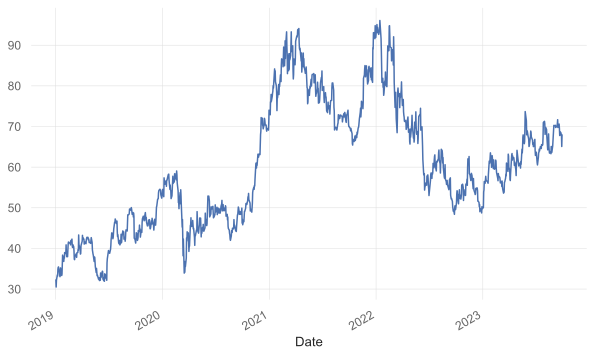

In [4]:
# Daily close price data for MU
mu_data.Close.plot()

## 2. Calculate returns, expected mean returns and risk

In [5]:
# Asset Returns/Rate of Returns: the cumulative daily rate of return is useful to determine /
#                                   the value of an investment at regular intervals.
data_close = mu_data[['Close']]
data_close.columns = ['MU']

returns = np.log(data_close / data_close.shift(1))
returns = returns.dropna()

# Expected Mean Returns
mean_returns = returns.mean()

# Volatility: market volatility is defined as the standard deviation of prices/returns.
vol = returns.std()

# Gain-Loss Ratio (GLR) represents the relative relationship of trades with a positive /
#                                       return and trades with a negative return
glr = returns[returns['MU'] > 0].sum() / returns[returns['MU'] < 0].sum().abs()

# Sharpe Ratio (SR) is the amount of excess return over the risk-free rate as the relevant measure of risk.
## rf is daily risk free rate.
# rf = (1.02 ** (1 / 360)) - 1

risk_free_rate = 0
sr = (mean_returns - risk_free_rate) / vol

# Compound Annual Growth Rate (CAGR)
cumulative_returns = returns.cumsum()
num_trading_days = len(returns)
cagr = (cumulative_returns['MU'][-1]) ** (252/num_trading_days) - 1

# Variance
var = returns.var() * 252

# CVAR
cvar = returns[returns <= np.percentile(returns, 5)].mean() * 252

# See metrics in table format
data_summary = pd.DataFrame({
    'Mean Returns': mean_returns,
    'Volatility': vol,
    'Gain-Loss Ratio (GLR)': glr,
    'Sharpe Ratio (SR)': sr,
    'CAGR': cagr,
    'Variance': var,
    'CVAR': cvar
})

data_summary


/var/folders/sl/vnrqj1bx3210p_r158j16qcw0000gn/T/ipykernel_77754/1702605445.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cagr = (cumulative_returns['MU'][-1]) ** (252/num_trading_days) - 1


,Mean Returns,Volatility,Gain-Loss Ratio (GLR),Sharpe Ratio (SR),CAGR,Variance,CVAR
MU,0.000624,0.029188,1.059818,0.02138,-0.060209,0.214685,-16.05826


## 3. Define statistical trading strategy (at least one, maximum 2)

In [6]:
# Exponential moving average (EMA) strategy
def ema_strategy(data, small, large):
    # Define your trading strategy based on the historical data
    # Example: Buy when the 20-day moving average is above the 100-day moving average, sell otherwise
    signals = pd.DataFrame(data)

    # EMA for 20 and 100-day windows
    signals['ema_short'] = signals['Close'].ewm(span = small, adjust = False).mean()
    signals['ema_long'] = signals['Close'].ewm(span = large, adjust = False).mean()
                         
    # Define a crossover strategy
    signals['bullish'] = 0.0
    signals['bullish'] = np.where(signals['ema_short'] > signals['ema_long'], 1, 0)
    signals['crossover'] = signals['bullish'].diff()

    # Calculate passive and strategy's returns
    signals['returns'] = np.log(signals['Close'] / signals['Close'].shift(1))
    signals['strategy'] = signals['bullish'].shift(1) * signals['returns']
    
    return signals

/var/folders/sl/vnrqj1bx3210p_r158j16qcw0000gn/T/ipykernel_77754/3328235721.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.plot(ema_strat['ema_long'][idx], 'ro', markersize = 5, color='#6a994e')
/var/folders/sl/vnrqj1bx3210p_r158j16qcw0000gn/T/ipykernel_77754/3328235721.py:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(ema_strat['ema_long'][idx], 'ro', markersize = 5, color='#6a994e')


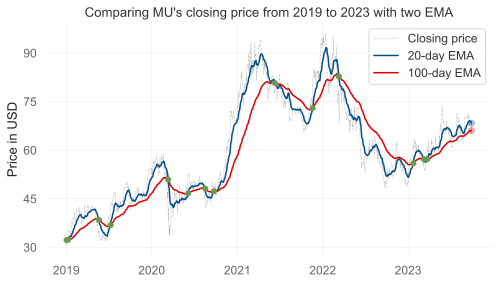

In [7]:
# Initiate strategy
ema_strat = ema_strategy(mu_data, 20, 100)

# Plot exponential moving averages for our strategy
# fig, ax = plt.subplots(figsize=(13.33,7.5), dpi = 96)
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(ema_strat['Close'], label='Closing price', color='grey', linestyle=':', linewidth=0.5)
ax.plot(ema_strat['ema_short'], label='20-day EMA', color='#014f86')
ax.plot(ema_strat.index[-1], ema_strat['ema_short'].iloc[-1], 'o', markersize=6, alpha=0.3, color='#014f86')
ax.plot(ema_strat['ema_long'], label='100-day EMA', color='#DC0000')
ax.plot(ema_strat.index[-1], ema_strat['ema_long'].iloc[-1], 'o', markersize=6, alpha=0.3, color='#DC0000')

# Plot crossovers
idx = np.argwhere(ema_strat['crossover']).flatten()
ax.plot(ema_strat['ema_long'][idx], 'ro', markersize = 5, color='#6a994e')

# Add Legend and Labels
ax.legend(loc='best')

# Prettify

## Create the grid 
ax.grid(which="major", axis='x', color='#DAD8D7', alpha=0.5, zorder=1)
ax.grid(which="major", axis='y', color='#DAD8D7', alpha=0.5, zorder=1)

## Reformat y-axis
ax.set_ylabel('Price in USD')
ax.yaxis.set_major_locator(plt.MaxNLocator(5))

## Remove the spines
ax.spines[['top','right','bottom']].set_visible(False)

## Make the left spine thicker
ax.spines['left'].set_linewidth(1.1)
# Add in title and subtitle
ax.set_title(label="Comparing MU's closing price from 2019 to 2023 with two EMA")
## Adjust the margins around the plot area
plt.subplots_adjust(left=None, bottom=0.2, right=None, top=0.85, wspace=None, hspace=None)

# Show the plot
plt.show()


<Axes: title={'center': 'Strategy Positioning'}, xlabel='Date'>

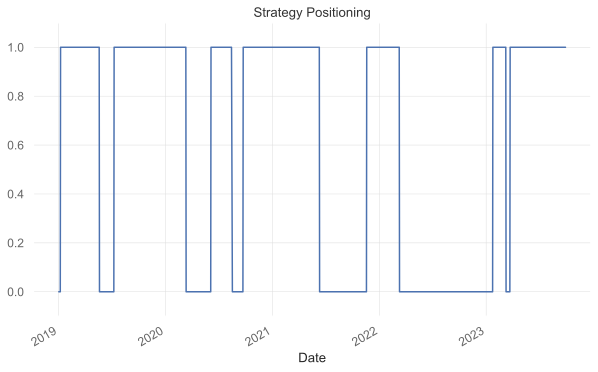

In [8]:
# Plot our strategy's positions
ema_strat['bullish'].plot(ylim=[-0.1, 1.1],
title='Strategy Positioning',
figsize=(10, 6))

returns     187.767570
strategy     29.788948
dtype: float64

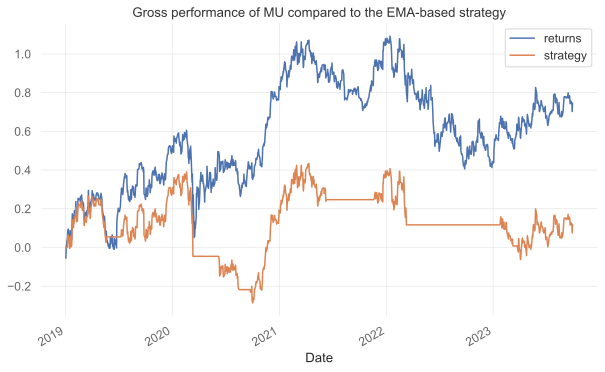

In [9]:
# Plot our strategy's returns compared to MU's stock performance
ema_strat[['returns', 'strategy']].cumsum().plot(figsize=(10, 6), 
                                                         title="Gross performance of MU compared to the EMA-based strategy")

ema_strat[['returns', 'strategy']].sum() * 252

## 4. Evaluate the efficacy of the trading strategy

In [10]:
qs.reports.metrics(ema_strat['strategy'])

                    Strategy
------------------  ----------
Start Period        2019-01-03
End Period          2023-09-29
Risk-Free Rate      0.0%
Time in Market      61.0%

Cumulative Return   -14.63%
CAGR﹪              -2.28%

Sharpe              0.07
Prob. Sharpe Ratio  56.32%
Sortino             0.1
Sortino/√2          0.07
Omega               1.02

Max Drawdown        -51.57%
Longest DD Days     1318

Gain/Pain Ratio     0.02
Gain/Pain (1M)      0.08

Payoff Ratio        0.98
Profit Factor       1.02
Common Sense Ratio  1.01
CPC Index           0.51
Tail Ratio          0.99
Outlier Win Ratio   6.5
Outlier Loss Ratio  2.64

MTD                 -3.04%
3M                  0.22%
6M                  11.14%
YTD                 -4.11%
1Y                  -4.11%
3Y (ann.)           4.68%
5Y (ann.)           -2.28%
10Y (ann.)          -2.28%
All-time (ann.)     -2.28%

Avg. Drawdown       -12.18%
Avg. Drawdown Days  170
Recovery Factor     0.23
Ulcer Index         0.29
Serenity Index      

## 5. Training a Deep Q-learning model in stock trading

In [11]:
# Import libraries for environment and model
from gym_anytrading.envs import StocksEnv, Actions, Positions
from stable_baselines3 import DQN

In [12]:
# Create a gym_anytrading environment using MU's stock data
env = gym.make('stocks-v0',
    df = pd.DataFrame(mu_data['Close']),
    window_size = 10,
    frame_bound = (10, len(mu_data)),
)

In [13]:
# Create a DQN model and set parameters
model = DQN("MlpPolicy",
            env = env, 
            buffer_size = 5000, #number of old observation steps saved ### podem aumentar 10000 ou 20000
            learning_starts = 200, # memory warmup ## podem aumentar 500, 1000
            train_freq = 1, # prediction network gets an update each train_freq's step ### aqui podem alterar 1,2,3,4
            batch_size = 4, # mini batch size drawn at each update step ### 8,16,32
            policy_kwargs = {'net_arch': [50,50]}, # hidden layer size of MLP ### podem alterar camadas e neurónios por camada: [100], [10,20],[50,100]
            exploration_fraction = 0.1, # Fraction of training steps the epsilon decays ### alterar aqui; 0.05, ou 0.2 
            target_update_interval = 100, # Target network gets updated each target_update_interval's step
            gamma = 0.9,
            verbose = 1, # verbosity of stable-basline's prints
            tau = 1e-4 ### fazer com 1e-5  (leva mais tempo)
            )

simulation_time = 5
tau = 1e-4
nb_steps = int(simulation_time // tau)

# Initiate learning and save finished model as zip file
model.learn(total_timesteps= nb_steps, log_interval=4)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.18e+03 |
|    ep_rew_mean      | 20.3     |
|    exploration_rate | 0.1      |
| time/               |          |
|    episodes         | 4        |
|    fps              | 273      |
|    time_elapsed     | 17       |
|    total_timesteps  | 4736     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00527  |
|    n_updates        | 4535     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.18e+03 |
|    ep_rew_mean      | 32.3     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 266      |
|    time_elapsed     | 35       |
|    total_timesteps  | 9472     |
| train/              |        

In [14]:
# Save learned model
# model.save("dqn_mu")
    
# Load saved model (zip file)
# model = DQN.load("dqn_mu")

In [15]:
# Reset environment to its initial state
observation, info = env.reset(seed=2023)

# Initiate dictionary to store action counts
action_stats = {Actions.Sell: 0, Actions.Buy: 0}

# Loop to apply the trained model on the environment
while True:
    action, _states = model.predict(observation)
    action_stats[Actions(action)] += 1
    observation, reward, terminated, truncated, info = env.step(action)

    if terminated or truncated:
        print("info:", info)
        print("action_stats:", action_stats)
        break

env.close()

info: {'total_reward': 7.666038513183594, 'total_profit': 0.31793997868271456, 'position': <Positions.Short: 0>}
action_stats: {<Actions.Sell: 0>: 1089, <Actions.Buy: 1>: 95}


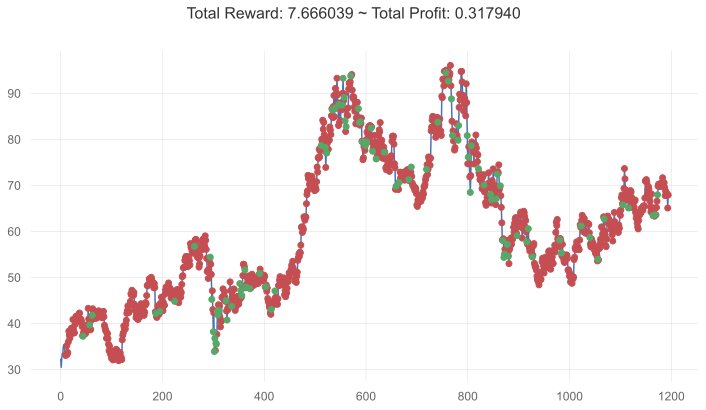

In [16]:
# Plot results
plt.figure(figsize=(12, 6))
env.unwrapped.render_all()
plt.show()

## 6. Evaluate the efficacy of the RL strategy

In [17]:
# Calculate metrics and visualize plots for the DeepQ-Learning strategy
qs.extend_pandas()

net_worth = pd.Series(env.unwrapped.history['total_profit'], index=mu_data.index[0:1184])
rl_returns = net_worth.pct_change().iloc[1:]

rl_returns = rl_returns.tz_localize(None)

qs.reports.metrics(rl_returns)

                    Strategy
------------------  ----------
Start Period        2019-01-03
End Period          2023-09-14
Risk-Free Rate      0.0%
Time in Market      8.0%

Cumulative Return   -68.21%
CAGR﹪              -15.5%

Sharpe              -1.48
Prob. Sharpe Ratio  0.02%
Sortino             -1.7
Sortino/√2          -1.2
Omega               0.39

Max Drawdown        -71.52%
Longest DD Days     1261

Gain/Pain Ratio     -0.61
Gain/Pain (1M)      -0.86

Payoff Ratio        0.78
Profit Factor       0.39
Common Sense Ratio  0.0
CPC Index           0.1
Tail Ratio          0.0
Outlier Win Ratio   35.87
Outlier Loss Ratio  1.56

MTD                 0.0%
3M                  -1.73%
6M                  -9.3%
YTD                 -13.87%
1Y                  -16.94%
3Y (ann.)           -21.1%
5Y (ann.)           -15.5%
10Y (ann.)          -15.5%
All-time (ann.)     -15.5%

Avg. Drawdown       -26.61%
Avg. Drawdown Days  539
Recovery Factor     1.52
Ulcer Index         0.45
Serenity Index    

## 7. Fine-tune your algorithms

### 7.1. Optimizing the Exponential Moving Averages parameters

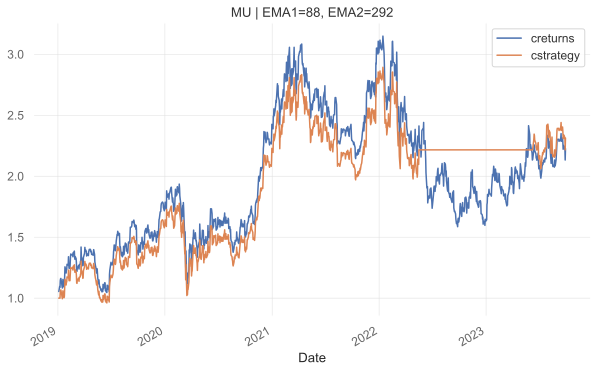

In [18]:
# Optimizing EMA strategy
import ema
ema_opt = ema.EMA('MU', 40, 20, "2019-01-01", "2023-09-30")

ema_opt.optimize_parameters((10, 100, 2), (100, 400, 2))

ema_opt.plot_results()

### 7.2. Hyperparameter tuning for RL strategy

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.18e+03 |
|    ep_rew_mean      | -10.3    |
|    exploration_rate | 0.1      |
| time/               |          |
|    episodes         | 4        |
|    fps              | 247      |
|    time_elapsed     | 19       |
|    total_timesteps  | 4736     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000475 |
|    n_updates        | 4535     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.18e+03 |
|    ep_rew_mean      | 0.688    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 236      |
|    time_elapsed     | 39       |
|    total_timesteps  | 9472     |
| train/              |        

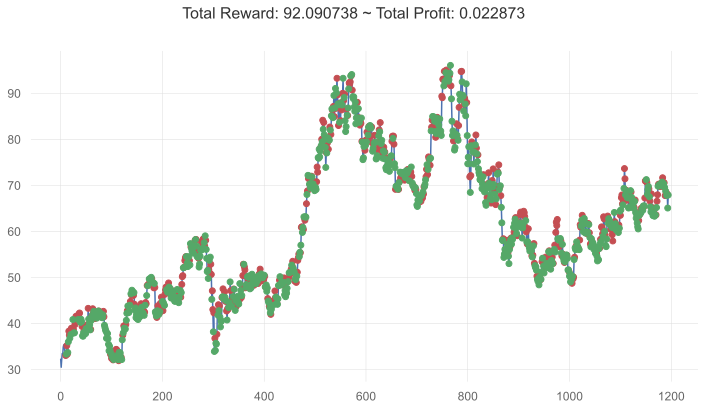

In [19]:
### podem correr vários modelos de redes neuronais, para detrminar qual arquitetura conduz a uma aprendizagem melhor
## para isso: podem alterar o número de camadas e de neurónios por camada (policy_kwargs)
## o gamma, o exploration_factor
## não façam mais do que 10-15 experiências

buffer_size = 5000 #number of old observation steps saved ### podem aumentar 10000 ou 20000
learning_starts = 200 # memory warmup ## podem aumentar 500, 1000
train_freq = 1 # prediction network gets an update each train_freq's step ### aqui podem alterar 1,2,3,4
batch_size = 4 # mini batch size drawn at each update step ### 8,16,32
policy_kwargs = {'net_arch': [50,50]} # hidden layer size of MLP ### podem alterar camadas e neurónios por camada: [100], [10,20],[50,100]
exploration_fraction = 0.1 # Fraction of training steps the epsilon decays ### alterar aqui; 0.05, ou 0.2 
target_update_interval = 100 # Target network gets updated each target_update_interval's step
gamma = 0.9
verbose = 1 # verbosity of stable-basline's prints
tau = 1e-4 ### fazer com 1e-5  (leva mais tempo)
simulation_time = 5 # seconds
nb_steps = int(simulation_time // tau)

### definir o modelo
model = DQN("MlpPolicy", env, buffer_size=buffer_size, learning_starts=learning_starts ,train_freq=train_freq, 
            batch_size=batch_size, gamma=gamma, policy_kwargs=policy_kwargs, 
            exploration_fraction=exploration_fraction, target_update_interval=target_update_interval,
            verbose=verbose)
### aprendizagem - deve aparecer no output prints da forma como aprende 
### se nada aparece, pode significar que não consegue aprender
model.learn(total_timesteps=nb_steps)

### test env

action_stats = {Actions.Sell: 0, Actions.Buy: 0}

observation, info = env.reset(seed=2000)

while True:
    # action = env.action_space.sample()
    action, _states = model.predict(observation)

    action_stats[Actions(action)] += 1
    observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated

    # env.render()
    if done:
        break

env.close()

print("action_stats:", action_stats)
print("info:", info)

### coloquei isso porque para evitar #dead kernel# quando quero fazer o plot
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"### coloquei isso porque para evitar #dead kernel# quando quero fazer o plot

### plot results
plt.figure(figsize=(12, 6))
env.unwrapped.render_all()
plt.show()

## 8. Compare and interpret the results

### 8.1. Compare between non-optimized and optimized EMA strategy

In [20]:
# Normal EMA
ema_norm = ema_strat['strategy'].tz_localize(None)
# Optimized EMA
ema_optz = ema_strategy(mu_data, 88, 292)
ema_optz = ema_optz['strategy'].tz_localize(None)

qs.reports.metrics(ema_optz, ema_norm)

                    Benchmark    Strategy
------------------  -----------  ----------
Start Period        2019-01-03   2019-01-03
End Period          2023-09-29   2023-09-29
Risk-Free Rate      0.0%         0.0%
Time in Market      61.0%        78.0%

Cumulative Return   -14.63%      53.6%
CAGR﹪              -2.28%       6.45%

Sharpe              0.07         0.43
Prob. Sharpe Ratio  56.32%       82.26%
Sortino             0.1          0.61
Sortino/√2          0.07         0.43
Omega               1.09         1.09

Max Drawdown        -51.57%      -46.06%
Longest DD Days     1318         942

Gain/Pain Ratio     0.02         0.09
Gain/Pain (1M)      0.08         0.58

Payoff Ratio        0.93         0.93
Profit Factor       1.02         1.09
Common Sense Ratio  1.01         1.12
CPC Index           0.48         0.54
Tail Ratio          0.99         1.03
Outlier Win Ratio   7.37         4.94
Outlier Loss Ratio  2.8          2.67

MTD                 -3.04%       -3.04%
3M            

### 8.1. Compare between optimized EMA strategy and optimized RL strategy

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a s

                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2019-01-09   2019-01-09
End Period                 2023-09-14   2023-09-14
Risk-Free Rate             0.0%         0.0%
Time in Market             78.0%        32.0%

Cumulative Return          62.57%       -97.8%
CAGR﹪                     7.43%        -43.04%

Sharpe                     0.46         -2.33
Prob. Sharpe Ratio         83.83%       0.0%
Smart Sharpe               0.45         -2.28
Sortino                    0.65         -2.86
Smart Sortino              0.64         -2.79
Sortino/√2                 0.46         -2.02
Smart Sortino/√2           0.45         -1.97
Omega                      0.49         0.49

Max Drawdown               -46.06%      -98.14%
Longest DD Days            927          1696
Volatility (ann.)          41.48%       32.61%
R^2                        0.0          0.0
Information Ratio          -0.11        -0.11
Calmar        

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2019-01-23,2023-09-12,2023-09-14,1696,-98.14271,-97.977055


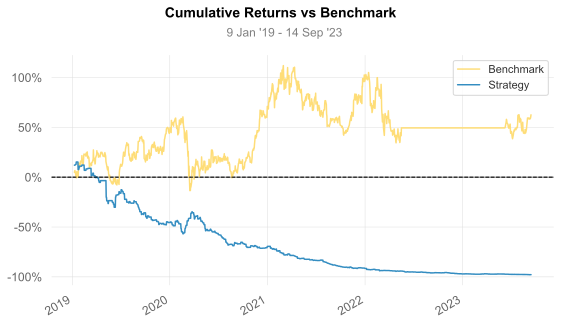

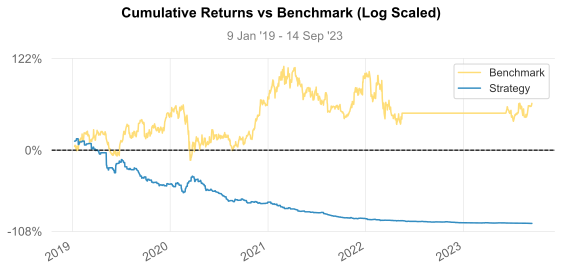

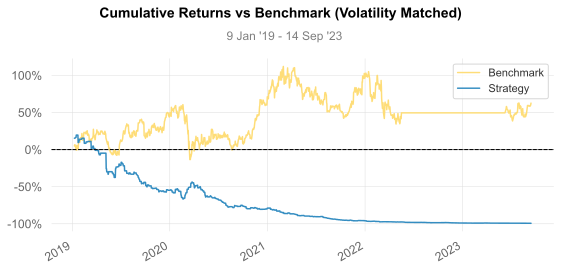

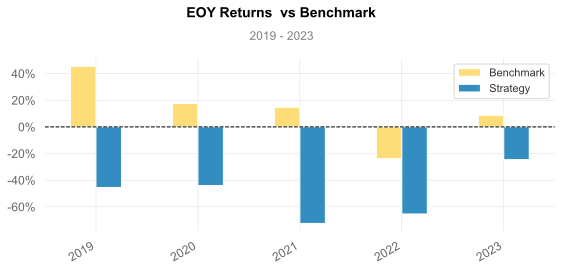

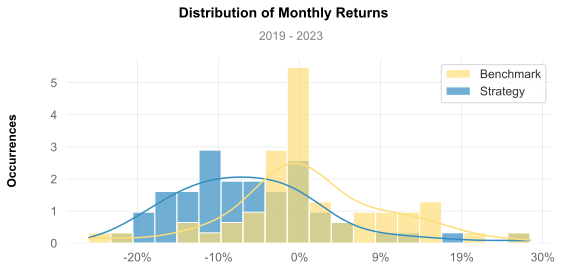

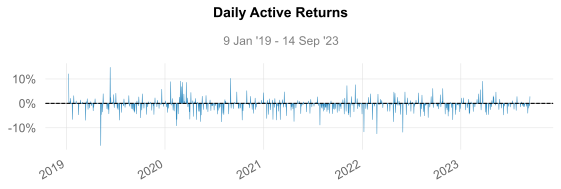

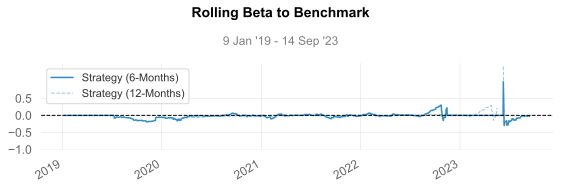

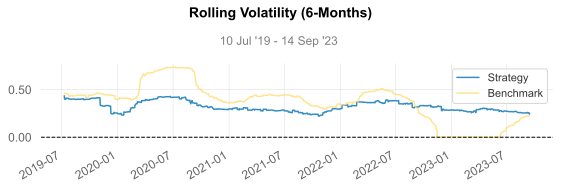

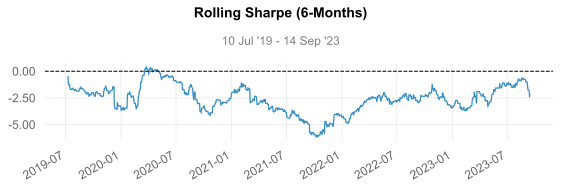

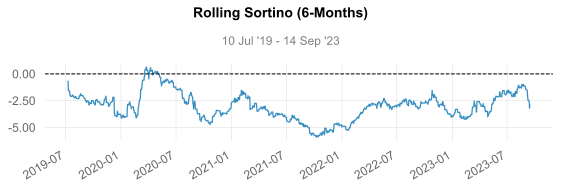

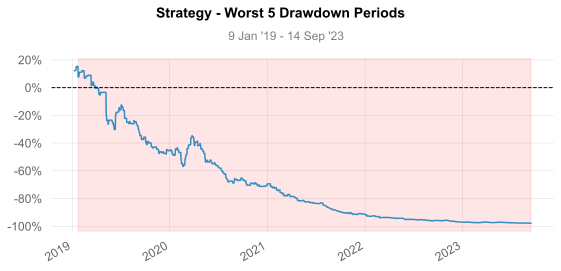

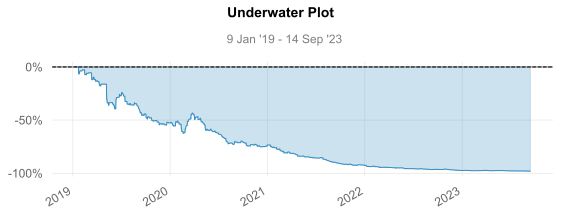

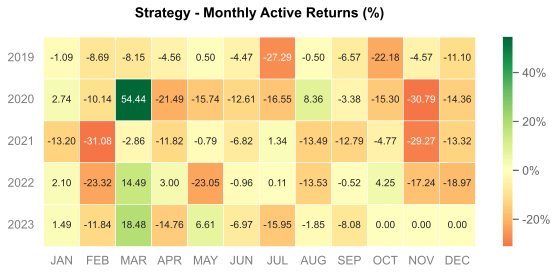

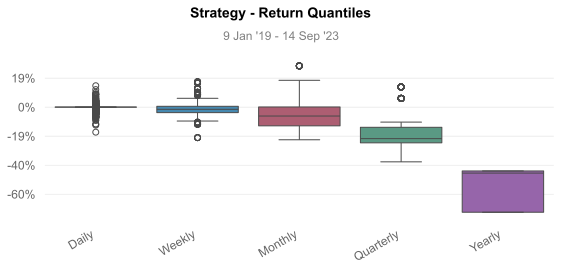

In [21]:
# Calculate metrics and visualize plots
qs.extend_pandas()

net_worth = pd.Series(env.unwrapped.history['total_profit'], index=mu_data.index[0:1184])
rl_returns = net_worth.pct_change().iloc[1:]

rl_returns = rl_returns.tz_localize(None)

qs.reports.full(rl_returns, ema_optz)